In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
from numpy import interp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D


from keras import backend as K
from keras import models 
from keras.utils.vis_utils import plot_model
from keras.models import Sequential

from itertools import cycle


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

from google.colab import drive

import pathlib

In [2]:
#Se monta la unidad de Google Drive
drive.mount('/content/gdrive', force_remount=True)

#Se almacenan los datos de la carpeta Train
data_train = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Train"
data_train = pathlib.Path(data_train)

#Se almacenan los datos de la carpeta Test
data_test = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Test"
data_test = pathlib.Path(data_test)


Mounted at /content/gdrive


In [3]:
#Se define el tamaño de entrada de las imagenes
IMAGE_SIZE=(224,224)
#Se define el tamaño del lote de datos que se utilizara 
BATCH_SIZE=15

In [4]:
datagen_kwargs = dict(rescale=1./255)

In [5]:
#Se utiliza la funcion ImageDataGenerator en conjunto con el diccionario para reescalar las imagenes de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
#Definimos los operadores para la modificacion de las imagenes en ImageGnerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
		zoom_range=0.1,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
    horizontal_flip=True,
    fill_mode= "nearest",
    **datagen_kwargs)

In [6]:
#Creamos el generador con los datos de prueba
test_generator = test_datagen.flow_from_directory(
    data_test, target_size=IMAGE_SIZE,  color_mode="rgb" ,batch_size=1450,
     class_mode='categorical',
     shuffle=False)
#Generador con los datos de 
train_generator = train_datagen.flow_from_directory(
    data_train, subset="training", shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
                   interpolation="bilinear", class_mode='categorical')

Found 1450 images belonging to 5 classes.
Found 5800 images belonging to 5 classes.


In [ ]:
#Extraccion de las variables X y Y del generador
x_test, y_test = next(test_generator)
x_train, y_train = next(train_generator)

In [ ]:
#Definicion de las metricas
#Sensibilidad
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
#Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#F1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 5*((precision*recall)/(precision+recall+K.epsilon()))
#Especificidad
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
#Creacion del modelo
resn_model = tf.keras.applications.ResNet101V2(input_shape=(224, 224,3), include_top=False, weights='imagenet')

resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = Sequential([resn_model,
                    GlobalAveragePooling2D(),
                    Flatten(),
                    Dense(5, activation='softmax')])

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

model.summary()


171327488/171317808 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 2048)              0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 5)                 10245     
Total params: 42,636,805
Trainable params: 39,579,653
Non-trainable params: 3,057,152
_________________________________________________________________


In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch).history

Epoch 1/10
386/386 [==============================] - 4517s 12s/step - loss: 0.4525 - accuracy: 0.8351
Epoch 2/10
386/386 [==============================] - 191s 494ms/step - loss: 0.2045 - accuracy: 0.9315
Epoch 3/10
386/386 [==============================] - 190s 493ms/step - loss: 0.1317 - accuracy: 0.9576
Epoch 4/10
386/386 [==============================] - 191s 494ms/step - loss: 0.1008 - accuracy: 0.9644
Epoch 5/10
386/386 [==============================] - 191s 493ms/step - loss: 0.0819 - accuracy: 0.9717
Epoch 6/10
386/386 [==============================] - 191s 494ms/step - loss: 0.0553 - accuracy: 0.9817
Epoch 7/10
386/386 [==============================] - 191s 494ms/step - loss: 0.0476 - accuracy: 0.9855
Epoch 8/10
386/386 [==============================] - 191s 494ms/step - loss: 0.0456 - accuracy: 0.9860
Epoch 9/10
386/386 [==============================] - 191s 494ms/step - loss: 0.0384 - accuracy: 0.9865
Epoch 10/10
386/386 [==============================] - 191s 493ms

In [ ]:
#Creacion de la matriz de confusion
model.load_weights("/detector_ResNet101V2_Ima_SM.h5")
y_pred=model.predict(x_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)
print(cm)
#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)
#Reporte de metricas
target_names = ['KN95', 'N95', 'Generico', 'Quirurgico', 'Sin_cubrebocas']
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

loss, accuracy = model.evaluate(test_generator, verbose=0)
print(loss, accuracy)

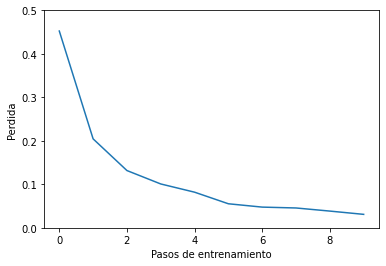

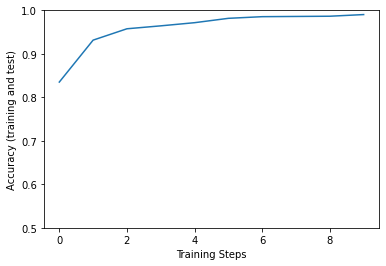

In [ ]:
#Grafica de las metricas
plt.figure()
plt.ylabel("Perdida")
plt.xlabel("Pasos de entrenamiento")
plt.ylim([0,0.5])
plt.plot(hist["loss"])

plt.figure()
plt.ylabel("Accuracy (training and test)")
plt.xlabel("Training Steps")
plt.ylim([0.5,1])
plt.plot(hist["accuracy"])

In [ ]:
plt.figure()
plt.ylabel("Especificidad")
plt.xlabel("Pasos de entrenamiento")
plt.ylim([0.9,1])
plt.plot(hist["specificity"])

plt.figure()
plt.ylabel("Sensibilidad")
plt.xlabel("Pasos de entrenamiento")
plt.ylim([0.6,1])
plt.plot(hist["recall_m"])

plt.figure()
plt.ylabel("Precision")
plt.xlabel("Pasos de entrenamiento")
plt.ylim([0.6,1])
plt.plot(hist["precision_m"])

In [ ]:
# Impresion de la curva ROC
lw = 2
y_score = model.predict(x_test)
n_classes= 5
# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculo de curva ROC Micropromedio y el area ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculo la curva ROC macro-promedio y el área ROC

# Agregar las tasas de los falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Luego interpole todas las curvas ROC en estos puntos
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Promedio y calcule el AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficacion de las cruvas por clase
plt.figure(1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

#Primer grafica de curvas ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.legend(loc="lower right")
plt.show()

#Zoom de la primer grafica 
plt.figure(2)
plt.xlim(0, 0.08)
plt.ylim(0.9, 1)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.ylabel('Sensibilidad')
plt.xlabel('1-especificidad')

plt.legend(loc="lower right")
plt.show()

In [ ]:
#Obtener aquellas imagenes mal clasificadas por el modelo
def get_class_string_from_index(index):
   for class_string, class_index in test_generator.class_indices.items():
      if class_index == index:
         return class_string

count=0
while count < len(x_test):
  image = x_test[count,: , :, :]
  true_index = np.argmax(y_test[count])
  
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
  predicted_index = np.argmax(prediction_scores)
  confidence= np.amax(prediction_scores)
  if true_index != predicted_index:
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("True label: " + get_class_string_from_index(true_index))
    print("Predicted label: " + get_class_string_from_index(predicted_index))
    print("Confidence: " + str(confidence))
  count+=1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Almacenar el modelo
model.save("/content/gdrive/MyDrive/modelo_Res101_Ima.h5", save_format="h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model6)
tflite_model = converter.convert()
#convertir el modelo a archivo tflite
with open('/content/gdrive/MyDrive/modelo_Res101_Ima.tflite', 'wb') as f:
  f.write(tflite_model)